# NEU (Reconfigurations Map and Related Functions)

### Basic Algorithm (NEU-OLS)

1. Perform Basic Algorithm (in this case OLS)
2. Map predictions to their graph; ie $x\mapsto (x,\hat{f}_{OLS}(x))$ where $\hat{f}_{OLS}$ is the least-squares regression function.

## Initializations:

In [1]:
# Deep Learning & ML
import tensorflow as tf
import tensorflow_probability as tfp
import keras as K
import keras.backend as Kb
from keras.layers import *

from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils
from scipy import linalg as scila

from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.constraints import NonNeg



# Linear Regression
from sklearn.linear_model import LinearRegression

# General
import numpy as np
import time

# Alerts
import os as beepsnd

# Others
import math

# General Outputs
print('TensorFlow:', tf.__version__)

Using TensorFlow backend.


TensorFlow: 2.1.0


In [2]:
N_Reconfigurations = 2
d = 1 # Dimension of X
D = 1 # Dimension of Y


# Data Meta-Parameters
noise_level = 0.1
uncertainty_level= 0.9

# Training meta-parameters
Pre_Epochs = 50
Full_Epochs = 50


# Number of Datapoints
N_data = 10**3
# Unknown Function
def unknown_f(x):
    return np.sin(x) #+ (x % 2)

# Generate Data
%run Data_Generator.ipynb

<Figure size 640x480 with 1 Axes>

#### Prepare data for NEU

In [3]:
# Reshape Data Into Compatible Shape
data_x = np.array(data_x).reshape(-1,d)
data_y = np.array(data_y)
# Perform OLS Regression
linear_model = LinearRegression()
reg = linear_model.fit(data_x, data_y)
model_pred_y = linear_model.predict(data_x)
# Map to Graph
data_NEU = np.concatenate((data_x,model_pred_y.reshape(-1,D)),1)
NEU_targets  = data_y.reshape(-1,D)

## Helper Functions:

In [4]:
#----------------------------#
# Helper Functions T/F Functions
#----------------------------#
def bump_True(x):
    x_out = 1- tf.math.pow(tf.math.abs(x),2)
    x_out = tf.math.exp(-tf.math.divide(1,x_out))
    return x_out

def bump_False(x):
    x_out = 0
    return x_out

# Approximation to max(0,x) function by smooth function
# https://math.stackexchange.com/questions/517482/approximating-a-maximum-function-by-a-differentiable-function
def abs_helper(x):
    return tf.math.sqrt(tf.math.pow(x,2)+(10**(-5)))

def max_helper(x):
    return tf.math.multiply(abs_helper(x) + x,.5)

def soft_indicator(x):
    return max_helper(tf.math.sign(x))

def bump_function(x):
    # Gaussian rescaled to [-1,1]^d
    bump_out = 1-tf.math.pow(x,2)        
    bump_out = tf.math.divide(-1,bump_out)
    bump_out = tf.math.exp(bump_out)
    # Indicator
    indicator = soft_indicator(1-x)
    # 0 outside of [-1,1]^d
    bump_out = tf.math.multiply(bump_out,indicator)
    return bump_out

### Build Reconfiguration Unit
$$
x \mapsto \exp\left(
\psi(x-c;\sigma) X
\right) (x-c) + c
$$
where:
#### Workflow
1. Shifts $x \in \mathbb{R}^d$ to $x- c$; c trainable.
2. Applies the map $\psi(x;\sigma)\triangleq e^{\frac{\sigma}{\sigma-|x|}}I_{\{|x|<\sigma\}}$ component-wise.  
3. Applies transformation $x \mapsto x +b$, $b \in \mathbb{R}^d$ trainable.
4. Applies the diagonalization map to that output: $ \left(x_1,\dots,x_d\right)\mapsto
                \begin{pmatrix}
                x_1 & & 0\\
                &\ddots &\\
                0 & & x_d\\
                \end{pmatrix}.$
5. Applies map $X \mapsto XA$, $A$ is a trainable $d\times d$ matrix.
6. Applies matrix exponential.
7. Multiplies output with result of (1).
8. Re-centers output to $x +c$ where $c$ is as in (1).

### Helper Function: Build and Training NEU Units (Core)

In [5]:
test = tf.constant(np.array([[0,1],[0,1]]))
#tf.TensorShape(tf.math.square(test.shape[1:]))

In [6]:
class Reconfiguration_unit_steps(tf.keras.layers.Layer):

    def __init__(self, *args, **kwargs):
        super(Reconfiguration_unit_steps, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.location_in = self.add_weight(name='location_in',
                                     shape=input_shape[1:],
                                     initializer='GlorotUniform',
                                     trainable=True)
        self.location_out = self.add_weight(name='location_out',
                                     shape=input_shape[1:],
                                     initializer='GlorotUniform',
                                     trainable=True)

###########################################################################################
        # Tangential ffNN
        self.tangential_ffNN_W1 = self.add_weight(name='TWeights1 ',
                                    shape=(input_shape[1], input_shape[1]),
                                    initializer='GlorotUniform',
                                    trainable=True)
        
        self.tangential_ffNN_b1 = self.add_weight(name='TBiases1',
                                    shape=input_shape[1:],
                                    initializer='ones',#Previously 'ones'
                                    trainable=True)
        
        self.tangential_ffNN_W2 = self.add_weight(name='TWeights2 ',
                                    shape=(input_shape[1], input_shape[1]),
                                    initializer='GlorotUniform',
                                    trainable=True)

        self.tangential_ffNN_b2 = self.add_weight(name='TBiases2',
                                    shape=input_shape[1:],
                                    initializer='ones',#Previously 'ones'
                                    trainable=True)
###########################################################################################
        # Bump Function
        self.sigma = self.add_weight(
                        name='sigma',
                        shape=[1],
                        initializer=RandomUniform(minval=.001, maxval=10),
                        trainable=True,
                        constraint=tf.keras.constraints.NonNeg()
                        )
        super().build(input_shape)
    
    def bump_function(self, x):
        return tf.math.exp(-self.sigma / (self.sigma - tf.math.pow(x, 2)))
    
    def call(self, input):
        # Input Processing
        #--------------------#
        recentered_input = input + self.location_in
        
        
        # Tangential ffNN: so_{d\times }
        #------------------------#
        # Tangential ffNN: Build
        T_ffNN = tf.linalg.matvec(self.tangential_ffNN_W1,recentered_input) + self.tangential_ffNN_b1
        T_ffNN = tf.nn.relu(T_ffNN)
        T_ffNN = tf.linalg.matvec(self.tangential_ffNN_W2,T_ffNN) + self.tangential_ffNN_b2

        # Anti-Symmetrize
        T_ffNN = tf.linalg.diag(T_ffNN)
        #x_out = T_ffNN
        
        # Apply Bump Function
        #------------------------------#
        # Logic: When to bump or not to bump
        greater = tf.math.greater(T_ffNN, -self.sigma)
        less = tf.math.less(T_ffNN, self.sigma)
        condition = tf.logical_and(greater, less)

        T_ffNN_bumped = tf.where(
            condition, 
            self.bump_function(tf.where(condition, T_ffNN, 0.0)),
            0.0)
        
        x_out = T_ffNN_bumped
        
        
        # Map so_d ->> SO_d
        #------------------------------#
        # **Note/fact:** TF uses Sylvester's method to for (fast) computation but this requires additional assumptions on the matrix which are typically not satified...
        # **Instead:** Use a truncated power series representation (standard definition of expm) of order 4
        x_out = tf.linalg.diag(tf.ones(d+D)) + x_out + tf.linalg.matmul(x_out,x_out)/2 + tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,x_out))/6 +tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,x_out)))/24 #+tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,x_out))))/120
        #x_out = tf.linalg.expm(x_out)
        
        # 8. Muliply by output of (1)
        x_out = tf.linalg.matvec(x_out,recentered_input)
        
        # 9. Recenter Transformed Data
        x_out = x_out + self.location_out
        
        # Return Output
        return x_out

### Helper Function: Projection Layer (For Regression)
Maps $\mathbb{X}\left((x,f(x))\mid \theta \right) \in \mathbb{R}^{d\times D}$ to an element of $\mathbb{R}^D$ by post-composing with the second canonical projection
$$
(x_1,x_2)\mapsto x_2
,
$$
where $x_1 \in \mathbb{R}^d$ and $x_2 \in \mathbb{R}^D$.  

In [7]:
projection_layer = tf.keras.layers.Lambda(lambda x: x[:, -D:])

## Robust Loss Function
This loss function prevents overfitting... it is especially userful for greedy approaches to training...like we use...

In [8]:
def above_percentile(x, p): #assuming the input is flattened: (n,)

    samples = Kb.cast(Kb.shape(x)[0], Kb.floatx()) #batch size
    p =  (100. - p)/100.  #100% will return 0 elements, 0% will return all elements

    #samples to get:
    samples = Kb.cast(tf.math.floor(p * samples), 'int32')
        #you can choose tf.math.ceil above, it depends on whether you want to
        #include or exclude one element. Suppose you you want 33% top,
        #but it's only possible to get exactly 30% or 40% top:
        #floor will get 30% top and ceil will get 40% top.
        #(exact matches included in both cases)

    #selected samples
    values, indices = tf.math.top_k(x, samples)

    return values

def Robust_MSE(p):
    def loss(y_true, y_predicted):
        ses = Kb.pow(y_true-y_predicted,2)
        above = above_percentile(Kb.flatten(ses), p)
        return Kb.mean(above)
    return loss

### Helper Functions: Compiling and Training NEU-OLS

#### First Unit
These are helper functions for training the reconfiguration map.

Build and greedily-initialize the first reconfiguration unit.

In [9]:
# define and fit the base model
def get_base_model(trainx, trainy, Pre_Epochs_in):
    # Define Model
    #----------------#
    # Initialize
    input_layer = tf.keras.Input(shape=[d+D])
    # Apply Reconfiguration Unit
    reconfigure  = Reconfiguration_unit_steps()
    current_layer = reconfigure(input_layer)
    # Output
    output_layer = projection_layer(current_layer)
    reconfiguration_basic = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
    
    # Compile Model
    #----------------#
    # Define Optimizer
    optimizer_on = tf.keras.optimizers.SGD(learning_rate=10**(-2), momentum=0.01, nesterov=True)
    # Compile
    reconfiguration_basic.compile(loss = Robust_MSE(uncertainty_level),
                    optimizer = optimizer_on,
                    metrics = ['mse'])
    
    # Fit Model
    #----------------#
    reconfiguration_basic.fit(trainx, trainy, epochs=Pre_Epochs_in, verbose=0)
        
    # Return Output
    return reconfiguration_basic

#### Greedy Initialization of Subsequent Units
Build reconfiguration and pre-train using greedy approach.

In [10]:
def add_reconfiguration_unit_greedily(model, trainx, trainy, Pre_Epochs_in):

    # Dissasemble Network
    layers = [l for l in model.layers]

    # Define new reconfiguration unit to be added
    new_reconfiguration_unit  = Reconfiguration_unit_steps()
    current_layer_new = new_reconfiguration_unit(layers[len(layers)-2].output)

    # Output Layer
    output_layer_new = projection_layer(current_layer_new)

    for i in range(len(layers)):
        layers[i].trainable = False


    # build model
    new_model = tf.keras.Model(inputs=[layers[0].input], outputs=output_layer_new)
    #new_model.summary()


    # Compile new Model
    #-------------------#
    # Define Optimizer
    optimizer_on = tf.keras.optimizers.SGD(learning_rate=10**(-2), momentum=0.01, nesterov=True)
    # Compile Model
    new_model.compile(loss = Robust_MSE(uncertainty_level),
                    optimizer = optimizer_on,
                    metrics = ['mse'])

    # Fit Model
    #----------------#
    new_model.fit(trainx, trainy, epochs=Pre_Epochs_in, verbose=0)

    # Return Output
    return new_model

#### Train and Compile (entire) reconfiguration using greedy-initializations past from previous helper functions.
Train reconfiguration together (initialized by greedy) layer-wise initializations.

In [11]:
def build_reconfiguration(model_greedy_initialized, trainx, trainy, Full_Epochs_in):

    # Dissasemble Network
    layers = [l for l in model_greedy_initialized.layers]

    # Define new reconfiguration unit to be added
    new_reconfiguration_unit  = Reconfiguration_unit_steps()
    current_layer_new = new_reconfiguration_unit(layers[len(layers)-2].output)

    # Output Layer
    output_layer_new = projection_layer(current_layer_new)

    for i in range(len(layers)):
        layers[i].trainable = True


    # build model
    reconfiguration = tf.keras.Model(inputs=[layers[0].input], outputs=output_layer_new)
    #new_model.summary()



    # Compile new Model
    #-------------------#
    # Define Optimizer
    optimizer_on = tf.keras.optimizers.SGD(learning_rate=10**(-5), momentum=0.01, nesterov=True)
    #optimizer_on = tf.keras.optimizers.Adagrad(learning_rate=10**(-5), initial_accumulator_value=0.1, epsilon=1e-07,name='Adagrad')

    # Compile Model
    reconfiguration.compile(loss = Robust_MSE(uncertainty_level),
                    optimizer = optimizer_on,
                    metrics = ['mse'])

    # Fit Model
    #----------------#
    reconfiguration.fit(trainx, trainy, epochs=Full_Epochs_in, verbose=1)

    # Return Output
    return reconfiguration

## Train NEU-OLS

In [12]:
# Base Model
model = get_base_model(data_NEU,NEU_targets,Pre_Epochs)

# Greedy Initialization
NEU_OLS_Greedy_init = get_base_model(data_NEU,NEU_targets,Pre_Epochs)
for i in range(N_Reconfigurations):
    # Update Model
    NEU_OLS_Greedy_init_temp = add_reconfiguration_unit_greedily(NEU_OLS_Greedy_init,data_NEU,NEU_targets,Pre_Epochs)
    
    # Check for Blowup
    if math.isnan(np.mean(NEU_OLS_Greedy_init.predict(data_NEU))):
        NEU_OLS_Greedy_init = NEU_OLS_Greedy_init
        break
    else: #Update Model if not explosion
        NEU_OLS_Greedy_init = NEU_OLS_Greedy_init_temp
    
    print(np.mean((NEU_OLS_Greedy_init.predict(data_NEU) - data_y)**2))
    
    # Update User on Status of Initialization
    print(((i+1)/N_Reconfigurations))

1.1196685821782695
0.5
3.212508996172275
1.0


In [13]:
# # Train Full Model Using Initializatoins
NEU_OLS = NEU_OLS_Greedy_init
NEU_OLS = build_reconfiguration(NEU_OLS,data_NEU,NEU_targets,Full_Epochs)

Train on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 8.8459 - mse: 8.5666
Epoch 2/50
1000/1000 [==============================] - 0s 107us/sample - loss: 8.8372 - mse: 8.5540
Epoch 3/50
1000/1000 [==============================] - 0s 101us/sample - loss: 8.8240 - mse: 8.5409
Epoch 4/50
1000/1000 [==============================] - 0s 96us/sample - loss: 8.8125 - mse: 8.5314
Epoch 5/50
1000/1000 [==============================] - 0s 105us/sample - loss: 8.7990 - mse: 8.5218
Epoch 6/50
1000/1000 [==============================] - 0s 101us/sample - loss: 8.7937 - mse: 8.5132
Epoch 7/50
1000/1000 [==============================] - 0s 108us/sample - loss: 8.7852 - mse: 8.5030
Epoch 8/50
1000/1000 [==============================] - 0s 106us/sample - loss: 8.7716 - mse: 8.4953
Epoch 9/50
1000/1000 [==============================] - 0s 103us/sample - loss: 8.7641 - mse: 8.4854
Epoch 10/50
1000/1000 [==============================] - 0s 106us/sample

## Make Predictions

In [14]:
# # Predictions (for comparison: TEMP)
NEU_OLS_prediction = NEU_OLS(data_NEU)
NEU_OLS_single_unit_prediction = model.predict(data_NEU)
NEU_OLS_greedy_initializations = NEU_OLS_Greedy_init.predict(data_NEU)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



# Visualize Predictions

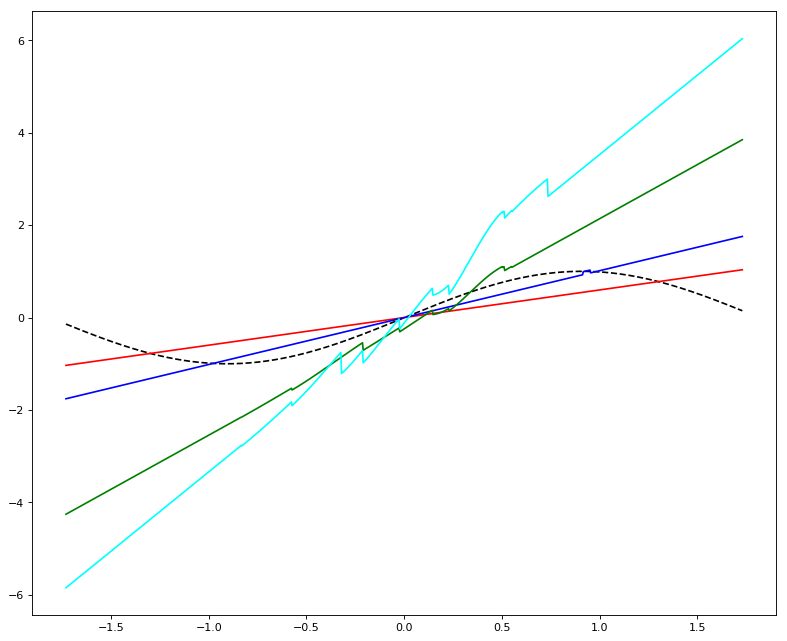

In [15]:
# Adjust Figure Details
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Data Plot
plt.plot(data_x,true_y,color='k',label='true',linestyle='--')

# Plot Models
plt.plot(data_x,model_pred_y,color='r',label='OLS')
plt.plot(data_x,NEU_OLS_single_unit_prediction,color='b',label='NEU_Unit')
plt.plot(data_x,NEU_OLS_greedy_initializations,color='g',label='NEU_Greedy_Init')
plt.plot(data_x,NEU_OLS_prediction,color='Aqua',label='NEU-OLS')

#### The END